In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [3]:
len(traindataset) // 32


419

In [4]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [5]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-06-25 09:49:44.986 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [6]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]

2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [7]:
import collections
count_labels = collections.Counter([traindataset[i][1] for  i in range(len(traindataset))])
{v: count_labels[v] / len(traindataset) for v in count_labels}
# TODO ~ about 4 lines of code

{'humor': 0.31414510476474533,
 'wiki': 0.31175900380284843,
 'proverbs': 0.06196405935426143,
 'reuters': 0.3121318320781448}

Geen normaal verdeling > weinig voorbeelden, check embedding

Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [8]:
# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        if label in d.keys():
            return d[label]

To test the preprocessor:

In [9]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
x=preprocessor([(x, y)])

In [10]:
x[1][0]

tensor(2)

# Set up the model
We can re-use the BaseDatastreamer

In [11]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [12]:
x, y = next(trainstreamer)
x.shape, y
x

tensor([[11202,  5398,  7658,  ...,     0,     0,     0],
        [   63,  3098,   251,  ...,     0,     0,     0],
        [   89,     3,    62,  ...,     0,     0,     0],
        ...,
        [ 1486,  1062,   106,  ...,     0,     0,     0],
        [    2,    24,   329,  ...,     0,     0,     0],
        [  538,     8,    53,  ...,     0,     0,     0]], dtype=torch.int32)

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [13]:
from src.models import metrics
import torch
# TODO ~ 2 lines of code
from torch.utils.data import DataLoader

metrics = [metrics.Accuracy()]

loss_fn = torch.nn.CrossEntropyLoss()


Opbasis van theorie MASE en crossentropyloss(). Next step misschien mogelijk metrics 2 toevoegen. Keuze accuracy > mogelijk meer groei in > literatuur nog opzoeken. 

## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [25]:

log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn
config = {
    "vocab": len(v),
    "hidden_size": 512,
    "num_layers": 3, # check num_layers
    "dropout": 0.1, # check dropout
    "output_size": 4,
}
from src.models import rnn
model = rnn.NLPmodel(config)


Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [15]:
len(traindataset)/32 # lengte traindataset gedeeld door de batchsize

419.09375

Dus je hebt 420 batches van 32

In [16]:
(len(traindataset) + len(testdataset)) / (32*25) # later nog checken

20.955

21 epoches dus

In [17]:
len(traindataset) / (32)

419.09375

In [18]:
420/25

16.8

Minimaal 17 epochs dus op basis van 25 train_steps. 

In [19]:
from src.training import train_model

model = train_model.trainloop(
    epochs=17,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


2022-06-25 09:49:50.337042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-25 09:49:50.337075: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-25 09:50:03.972 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220625-0950
  0%|          | 0/17 [00:02<?, ?it/s]


KeyboardInterrupt: 

Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

your explanation here

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

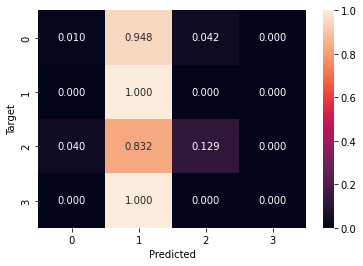

In [20]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

- What is going on?
- What is a good metric here?
- how is your answer to Q1 relevant here?
- Is there something you could do to fix/improve things, after you see these results?

Je ziet hier de uitkomst tussen neit normale verdeling van de dataset. Mogleijk datamodificeren zodat er meer data van die groep binnenkomt. Geen data weggooien. Misschien meer gewicht meegen aan de groep 

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

In [ ]:
#filter groter maken, le groter maken ( is nu vrij klein) 

Hierbij hebben we een nieuwe class toegevoegd in de rnn models. Dit is de AttentionNLP > hierbij zit dus een attional layer tussen de GRU en linear. Dit zorgt voor meer contest in het verhaal. 

In [26]:
model = rnn.AttentionNLP(config)



20220625-0936 zonder attention layer
20220625-0938 met attenlion layer. Zorg voor lagere loss en hogere accurcy. 
Nog to do learnin grate spelen en trains steps. 

test op meer filters om 12:05 > zorgt mogelijk over overfitting > telkens copies maken. Met meer filters wel hogere accurcy direct in het begin (20220625-0957)

In [27]:
model = train_model.trainloop(
    epochs=40,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)

2022-06-25 09:57:31.194 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220625-0957
100%|██████████| 25/25 [00:11<00:00,  2.23it/s]
2022-06-25 09:57:44.853 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.0285 test 0.7756 metric ['0.7412']
100%|██████████| 25/25 [00:09<00:00,  2.60it/s]
2022-06-25 09:57:56.838 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 0.7888 test 0.6402 metric ['0.7887']
100%|██████████| 25/25 [00:09<00:00,  2.64it/s]
2022-06-25 09:58:08.678 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 0.6609 test 0.5061 metric ['0.8213']
100%|██████████| 25/25 [00:09<00:00,  2.52it/s]
2022-06-25 09:58:20.885 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 0.5575 test 0.5062 metric ['0.8213']
100%|██████████| 25/25 [00:09<00:00,  2.72it/s]
2022-06-25 09:58:32.592 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train 0.5051 test 0.4795 metric ['0.8200']
10